In [ ]:
!pip install backtrader[plotting]


     |████████████████████████████████| 419kB 2.7MB/s 


In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class Aroon_oscillator(bt.Strategy):
    params = (
        ('maperiod', 14),('ema_p',30)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Crossover between Aroon Oscillator and Aroon Oscillator EMA
        self.Aroon = bt.indicators.AroonOscillator(
            self.datas[0], period=self.params.maperiod)
        self.Aroon_EMA =  bt.indicators.ExponentialMovingAverage(self.Aroon, period=self.params.ema_p)
        self.Cross_Aroon= bt.indicators.CrossOver(self.Aroon,self.Aroon_EMA,plotname='Buy_Sell_Line')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.Cross_Aroon>0:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.Cross_Aroon < 0 :
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 10000.00
2018-04-11, BUY CREATE, 41.73
2018-04-12, BUY EXECUTED, Price: 41.96, Cost: 4196.00, Comm 0.00
2018-04-23, SELL CREATE, 39.98
2018-04-24, SELL EXECUTED, Price: 40.09, Cost: 4196.00, Comm 0.00
2018-05-04, BUY CREATE, 44.48
2018-05-07, BUY EXECUTED, Price: 44.81, Cost: 4481.00, Comm 0.00
2018-05-25, SELL CREATE, 45.81
2018-05-29, SELL EXECUTED, Price: 45.57, Cost: 4481.00, Comm 0.00
2018-06-01, BUY CREATE, 46.21
2018-06-04, BUY EXECUTED, Price: 46.55, Cost: 4655.00, Comm 0.00
2018-06-14, SELL CREATE, 46.35
2018-06-15, SELL EXECUTED, Price: 46.16, Cost: 4655.00, Comm 0.00
2018-07-09, BUY CREATE, 46.29
2018-07-10, BUY EXECUTED, Price: 46.33, Cost: 4633.00, Comm 0.00
2018-08-01, SELL CREATE, 48.95
2018-08-02, SELL EXECUTED, Price: 48.72, Cost: 4633.00, Comm 0.00
2018-08-09, BUY CREATE, 50.74
2018-08-10, BUY EXECUTED, Price: 50.55, Cost: 5055.00, Comm 0.00
2018-08-23, SELL CREATE, 52.53
2018-08-24, SELL EXECUTED, Price: 52.80, Cost: 5055.00, Comm 0.00
2018-

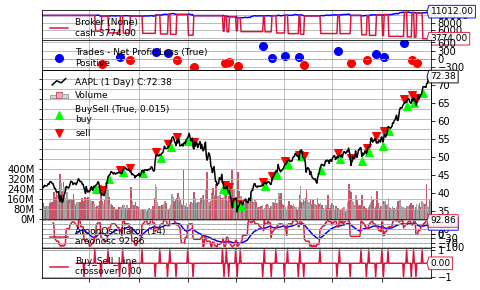

In [ ]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(Aroon_oscillator)

        # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname='AAPL',
        # Do not pass values before this date
        fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2019, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(iplot = False)